# BANK REVIEW ANALYSIS

### import required packages

In [2]:

#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
#import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords

#import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import  textblob
import xgboost
#from keras.preprocessing import text, sequence
#from keras import layers, models, optimizers

from textblob import TextBlob
from nltk.stem import PorterStemmer
import nltk
nltk.download('wordnet')
from textblob import Word

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sajid\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Reading bankreviews.csv file  into dataframe

In [3]:
data = pd.read_excel('BankReviews.xlsx')

In [4]:
data.head()

,Date,Stars,Reviews,BankName
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


In [5]:
data=data[['Reviews', 'Stars']]

In [7]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sajid\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Basic exploratory Analysis

In [8]:
data['Reviews'] = data['Reviews'].astype(str)
data['count_sent']=data["Reviews"].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Word count in each comment:
data['count_word']=data["Reviews"].apply(lambda x: len(str(x).split()))

#Unique word count
data['count_unique_word']=data["Reviews"].apply(lambda x: len(set(str(x).split())))

#Letter count
data['count_letters']=data["Reviews"].apply(lambda x: len(str(x)))

#Word density

data['word_density'] = data['count_letters'] / (data['count_word']+1)

#punctuation count
data["count_punctuations"] =data["Reviews"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
data["count_words_upper"] = data["Reviews"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#upper case words count
data["count_words_lower"] = data["Reviews"].apply(lambda x: len([w for w in str(x).split() if w.islower()]))

#title case words count
data["count_words_title"] = data["Reviews"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
data["count_stopwords"] = data["Reviews"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

#Average length of the words
data["mean_word_len"] = data["Reviews"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#Number of numeric
data['numeric'] = data['Reviews'].apply(lambda x :len([x for x in x.split() if x.isdigit()]))

#Number of alphanumeric
data['alphanumeric'] = data['Reviews'].apply(lambda x :len([x for x in x.split() if x.isalnum()]))

#Number of alphabetics
data['alphabetetics'] = data['Reviews'].apply(lambda x :len([x for x in x.split() if x.isalpha()]))

#Number of alphabetics
data['Spaces'] = data['Reviews'].apply(lambda x :len([x for x in x.split() if x.isspace()]))

#Number of Words ends with
data['words_ends_with_et'] = data['Reviews'].apply(lambda x :len([x for x in x.lower().split() if x.endswith('et')]))

#Number of Words ends with
data['words_start_with_no'] = data['Reviews'].apply(lambda x :len([x for x in x.lower().split() if x.startswith('no')]))

# Count the occurences of all words
data['wordcounts'] = data['Reviews'].apply(lambda x :dict([ [t, x.split().count(t)] for t in set(x.split()) ]))

pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

data['noun_count'] = data['Reviews'].apply(lambda x: check_pos_tag(x, 'noun'))
data['verb_count'] = data['Reviews'].apply(lambda x: check_pos_tag(x, 'verb'))
data['adj_count']  = data['Reviews'].apply(lambda x: check_pos_tag(x, 'adj'))
data['adv_count']  = data['Reviews'].apply(lambda x: check_pos_tag(x, 'adv'))
data['pron_count'] = data['Reviews'].apply(lambda x: check_pos_tag(x, 'pron')) 

### Calculating sentiment  analysis using Textblob module

In [9]:
data['sentiment'] = data["Reviews"].apply(lambda x: TextBlob(x).sentiment.polarity )

In [10]:
data.head()

,Reviews,Stars,count_sent,count_word,count_unique_word,count_letters,word_density,count_punctuations,count_words_upper,count_words_lower,...,Spaces,words_ends_with_et,words_start_with_no,wordcounts,noun_count,verb_count,adj_count,adv_count,pron_count,sentiment
0,"Great job, Wyndham Capital! Each person was pr...",5,1,19,19,126,6.300000,4,0,14,...,0,0,0,"{'Each': 1, 'through': 1, 'process': 1, 'move'...",8,3,1,1,3,0.533333
1,Matthew Richardson is professional and helpful...,5,1,25,23,159,6.115385,4,0,20,...,0,0,0,"{'product': 1, 'is': 1, 'Matthew!': 1, 'He': 1...",7,3,4,2,4,0.453333
2,We had a past experience with Wyndham Mortgage...,5,1,79,64,462,5.775000,8,0,64,...,0,0,1,"{'without': 1, 'with': 1, 'team': 1, 'past': 1...",24,10,5,8,8,-0.033231
3,We have been dealing with Brad Thomka from the...,5,1,108,78,605,5.550459,9,0,88,...,0,0,1,"{'recommend': 1, 'on': 1, 'us': 2, 'beginning'...",30,17,8,7,11,0.093740
4,I can't express how grateful I am for the supp...,5,1,59,47,341,5.683333,6,3,50,...,0,0,1,"{'how': 1, 'is': 1, 'with': 1, 'I': 3, 'He': 1...",16,9,4,4,8,0.125000


In [11]:
data['sentiment_cat'] = np.where(data.sentiment>0.1,'Positive', 'Negative')

In [12]:
data.sentiment_cat.value_counts()

Positive    415
Negative     90
Name: sentiment_cat, dtype: int64

In [13]:
data.Stars.value_counts()

5    410
1     95
Name: Stars, dtype: int64

In [16]:
pd.crosstab(data.sentiment_cat, data.Stars)

Stars,1,5
sentiment_cat,,
Negative,61,29
Positive,34,381


### Splitting the data into train and test

In [17]:
# define X and y
X = data.Reviews
y = data.Stars

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(378,)
(127,)
(378,)
(127,)


In [18]:
data.head()

,Reviews,Stars,count_sent,count_word,count_unique_word,count_letters,word_density,count_punctuations,count_words_upper,count_words_lower,...,words_ends_with_et,words_start_with_no,wordcounts,noun_count,verb_count,adj_count,adv_count,pron_count,sentiment,sentiment_cat
0,"Great job, Wyndham Capital! Each person was pr...",5,1,19,19,126,6.300000,4,0,14,...,0,0,"{'our': 1, 'us': 1, 'process': 1, 'smoothly.':...",8,3,1,1,3,0.533333,Positive
1,Matthew Richardson is professional and helpful...,5,1,25,23,159,6.115385,4,0,20,...,0,0,"{'the': 2, 'us': 1, 'our': 1, 'find': 1, 'for'...",7,3,4,2,4,0.453333,Positive
2,We had a past experience with Wyndham Mortgage...,5,1,79,64,462,5.775000,8,0,64,...,0,1,"{'the': 3, 'our': 1, 'us': 2, 'team': 1, 'past...",24,10,5,8,8,-0.033231,Negative
3,We have been dealing with Brad Thomka from the...,5,1,108,78,605,5.550459,9,0,88,...,0,1,"{'the': 6, 'our': 1, 'us': 2, 'were': 1, 'Sinc...",30,17,8,7,11,0.093740,Negative
4,I can't express how grateful I am for the supp...,5,1,59,47,341,5.683333,6,3,50,...,0,1,"{'the': 4, 'working': 1, 'took': 1, 'process':...",16,9,4,4,8,0.125000,Positive


### Creating user  defined functions for cleaning reviews data and and preprocess the data

In [19]:
#Abbrevations and Words correction
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub(r' +', ' ', text)
    text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,'0-9]", "", text)
    return(text)

In [20]:
stop = set(nltk.corpus.stopwords.words('english'))

In [21]:
import string
def pre_process(text):
    #text = text.str.replace('/','')                           #Replacing the / with none
    #text = text.apply(lambda x: re.sub("  "," ", x))          #Replacing double space with single space
    #text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,']", "", text)      #Replacing special character with none
    #text = re.sub(r'[0-9]+', '', text)                        #Replacing numbers with none
    #text = text.apply(lambda x: " ".join(x.translate(str.maketrans('', '', string.punctuation)) for x in x.split() if x.isalpha()))
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop)) #Removing stop words
    #text = text.apply(lambda x: str(TextBlob(x).correct()))                      #Correct spelling corrections
    #text = text.apply(lambda x: " ".join(PorterStemmer().stem(word) for word in x.split())) #Stemming using porter stemmer
    #text = text.apply(lambda x: " ".join(stemmer_func(word) for word in x.split()))        #Stemming
    #text = text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))   #lemmatization
    #text = text.apply(lambda x: " ".join(word for word, pos in pos_tag(x.split()) if pos not in ['NN','NNS','NNP','NNPS'])) #Removing nouns etc
    return(text)

In [22]:
X_train = X_train.apply(lambda x: clean_text(x))
X_test = X_test.apply(lambda x: clean_text(x))

In [23]:
X_train=pre_process(X_train)
X_test=pre_process(X_test)

In [24]:
from sklearn.externals import joblib

In [25]:
joblib.dump(X_train, 'X_train.pkl')

['X_train.pkl']

### Vectorization(Count,TfiDf)

In [26]:
#Train
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             encoding='latin-1' ,
                             max_features=800)
xtrain_count = count_vect.fit_transform(X_train)


#### Viewing the document term metrics

In [27]:
dtm=xtrain_count.toarray()

In [28]:
dtm

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [29]:
count_vect.get_feature_names()

['aaron',
 'able',
 'absolutely',
 'accept',
 'accommodating',
 'account',
 'accurate',
 'across',
 'actual',
 'adam',
 'additional',
 'advice',
 'agent',
 'agreed',
 'alex',
 'almost',
 'along',
 'already',
 'also',
 'always',
 'amazing',
 'american',
 'amount',
 'another',
 'answer',
 'answered',
 'answering',
 'answers',
 'anyone',
 'anything',
 'application',
 'apply',
 'appraisal',
 'appraiser',
 'appreciate',
 'appreciated',
 'approved',
 'around',
 'ask',
 'asked',
 'asking',
 'aspects',
 'attention',
 'available',
 'away',
 'awesome',
 'back',
 'bad',
 'balance',
 'bank',
 'banks',
 'barrett',
 'based',
 'became',
 'beginning',
 'beneficial',
 'best',
 'better',
 'beyond',
 'big',
 'bob',
 'brent',
 'broker',
 'business',
 'buy',
 'buyer',
 'buyers',
 'buying',
 'ca',
 'call',
 'called',
 'calling',
 'calls',
 'calm',
 'came',
 'cannot',
 'cant',
 'capital',
 'care',
 'causing',
 'certainly',
 'change',
 'changed',
 'check',
 'chose',
 'chris',
 'circumstances',
 'clear',
 'cli

In [30]:
dtm1=pd.DataFrame(dtm)

In [31]:
dtm1.columns=count_vect.get_feature_names()

In [32]:
dtm1.head()

,aaron,able,absolutely,accept,accommodating,account,accurate,across,actual,adam,...,working,works,would,wouldnt,writing,wrong,wyndham,year,years,yet
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
word_freq = pd.DataFrame(dtm1.apply(sum).head(20), columns=['freq'])
word_freq.sort_values('freq', ascending=False, inplace=True)

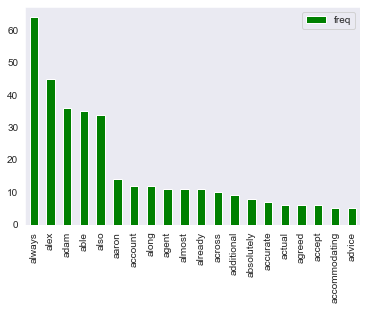

In [34]:
word_freq.plot(kind='bar', color='Green')

In [35]:
word_freq_dictionary = dict(dtm1.apply(sum))

### Generating word clouds using word frequencies (dictionary)

In [36]:
from wordcloud import WordCloud ,STOPWORDS
wordcloud = WordCloud(background_color='white', stopwords=stop)

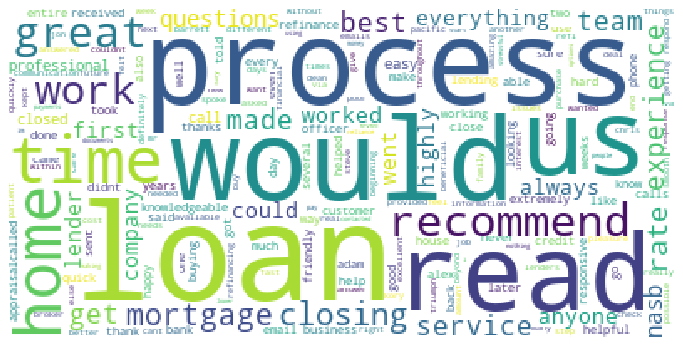

In [37]:
wordcloud = wordcloud.generate_from_frequencies(word_freq_dictionary)

fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

### Generate wordcloud based on words

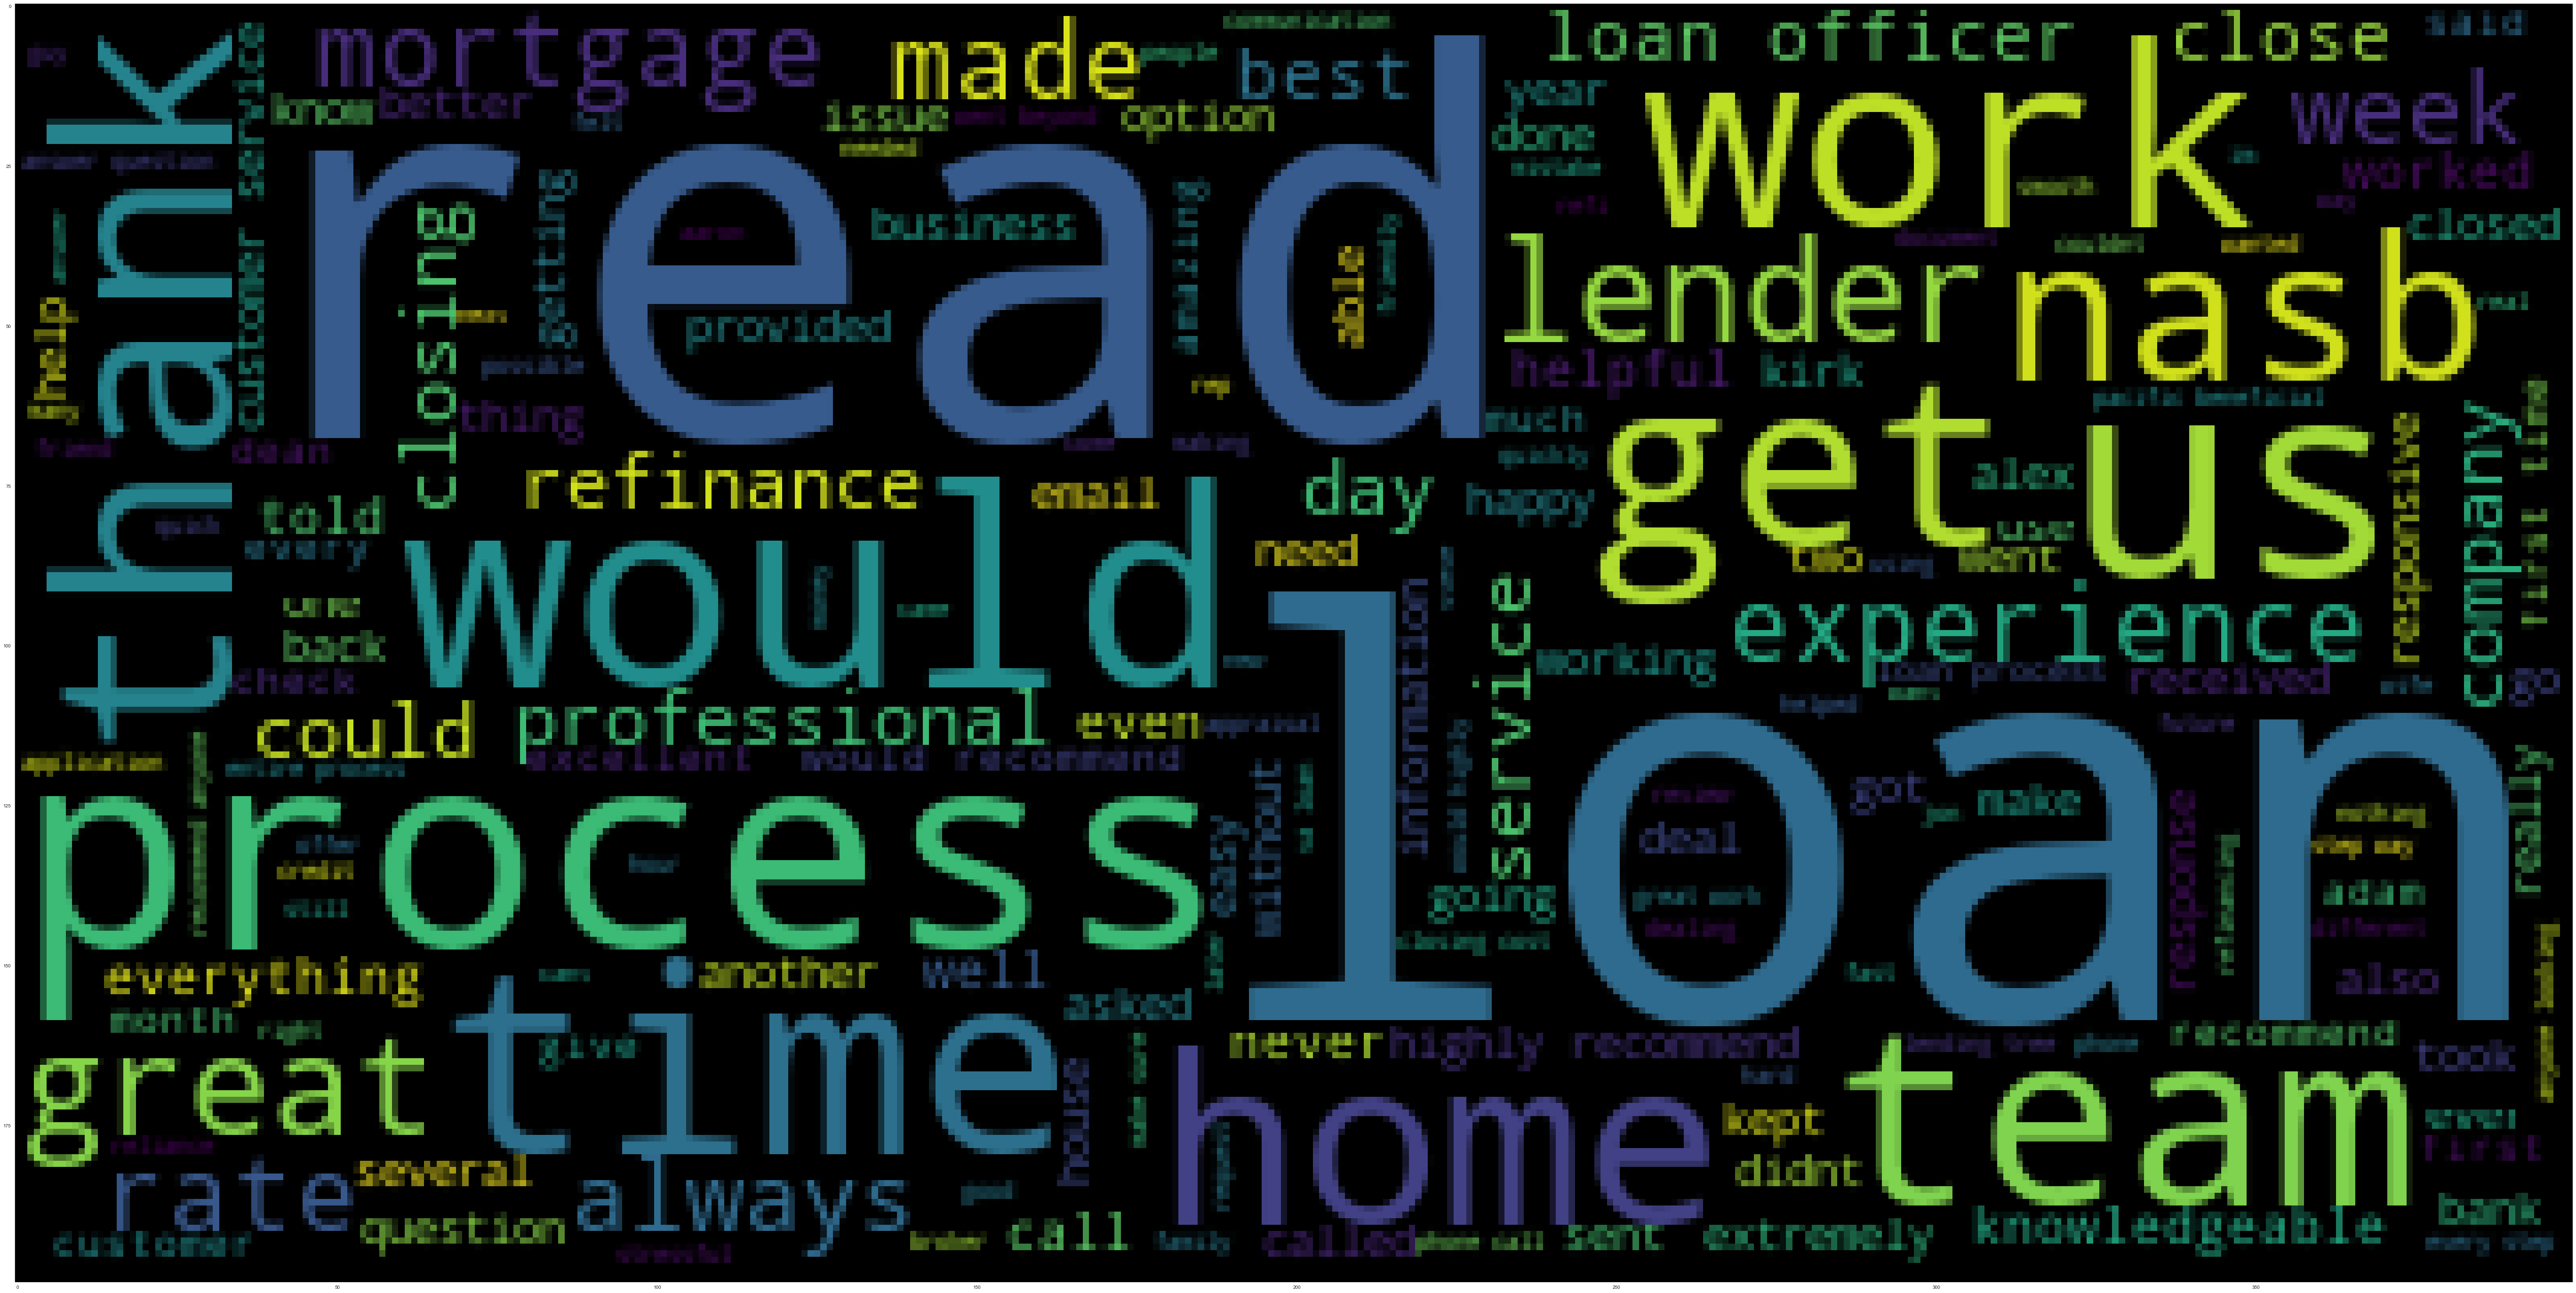

In [38]:
wordcloud = WordCloud(stopwords=[]).generate(' '.join(X_train.tolist()))

%matplotlib inline
fig = plt.figure(figsize=(200,50))
plt.imshow(wordcloud)

### Vectorization (count, tfidf) for both train & test

In [39]:
#Train
count_vect = CountVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             lowercase = True,
                             encoding='latin-1' , 
                             max_features=1000)
X_train_count = count_vect.fit_transform(X_train)

tfidf_vect = TfidfVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             encoding='latin-1' , 
                             lowercase = True,
                             max_features=1000)
X_train_tfidf = tfidf_vect.fit_transform(X_train)

#Test
X_test_count = count_vect.transform(X_test)
X_test_tfidf = tfidf_vect.transform(X_test)


In [40]:
dtm_count=pd.DataFrame(X_train_count.toarray(), columns=count_vect.get_feature_names())
dtm_tfidf=pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vect.get_feature_names())

## Topic Modelling using Gensim

In [41]:
# Importing Gensim
import gensim
from gensim import corpora

In [42]:
X_train_tokens = [doc.split() for doc in X_train]  

In [43]:
dictionary = corpora.Dictionary(X_train_tokens)
print(dictionary)

Dictionary(2381 unique tokens: ['accept', 'agreed', 'already', 'also', 'asking']...)


In [44]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in X_train_tokens]

In [45]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

In [46]:
# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary,passes=1)

In [47]:
print(ldamodel.print_topics(num_topics=10, num_words=50))

[(0, '0.020*"us" + 0.012*"would" + 0.011*"got" + 0.010*"loan" + 0.010*"done" + 0.009*"read" + 0.009*"process" + 0.008*"work" + 0.008*"closing" + 0.007*"home" + 0.007*"team" + 0.007*"kirk" + 0.007*"steve" + 0.006*"great" + 0.006*"barrett" + 0.005*"time" + 0.005*"even" + 0.005*"beginning" + 0.005*"mr" + 0.005*"experience" + 0.005*"rate" + 0.005*"questions" + 0.005*"company" + 0.005*"good" + 0.004*"best" + 0.004*"call" + 0.004*"get" + 0.004*"first" + 0.004*"day" + 0.004*"mortgage" + 0.004*"job" + 0.004*"recommend" + 0.004*"email" + 0.004*"thank" + 0.004*"appraisal" + 0.004*"poor" + 0.004*"couldnt" + 0.003*"contacted" + 0.003*"times" + 0.003*"make" + 0.003*"end" + 0.003*"never" + 0.003*"certainly" + 0.003*"jon" + 0.003*"know" + 0.003*"went" + 0.003*"adam" + 0.003*"buy" + 0.003*"sure" + 0.003*"customer"'), (1, '0.013*"recommend" + 0.012*"great" + 0.011*"time" + 0.011*"process" + 0.009*"loan" + 0.009*"would" + 0.008*"home" + 0.008*"read" + 0.008*"work" + 0.007*"nasb" + 0.007*"first" + 0.007*

In [48]:
topics = ldamodel.show_topics(formatted=False, num_words=100)
    
for t in range(len(topics)):
    print("\nTopic {}, top {} words:".format(t+1,100))
    print(" ".join([w[0] for w in topics[t][1]]))


Topic 1, top 100 words:
us would got loan done read process work closing home team kirk steve great barrett time even beginning mr experience rate questions company good best call get first day mortgage job recommend email thank appraisal poor couldnt contacted times make end never certainly jon know went adam buy sure customer could credit provided via always received officer answered peter better working every mistake kept called let entire fast nasb information despite various person responses buying i’ll bank lower business amazing things response professional house twice step enjoyed somehow weeks asked going helpful service roadblocks prompt help real guy amount happy

Topic 2, top 100 words:
recommend great time process loan would home read work nasb first thanks best highly experience always mortgage closing service made lender professional company everything every questions rate easy call communication us customer worked get kirk going working said close really email house to

### Topic modelling usinhg sklearn.decomposition

In [49]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(X_train_tfidf)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

In [50]:
# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

topic_summaries

['fred make went true come works including smoothly making beyond',
 'joey friendly timely helpful appreciated responses chose manner pleased wife',
 'alex informative pleasure responsive jocovic realtor lenders bob ask able',
 'done job getting patient still issues steve get didnt well',
 'time professional kory closing team work efficient va entire process',
 'tried lender calling got hold back sent couldnt wyndham us',
 'mortgage process made website jon step office great questions amazing',
 'oriented customer professional purchasing wouldnt less new purchase much never',
 'trusted company true joey failed positive paperwork mortgage ve expectations',
 'great responsive service chris helpful always fred process timely awesome',
 'thorough quick close cost friendly find original week professional issues',
 'rate staff check job friendly company wyndham informed process documentation',
 'loan would us rate read process best get always home',
 'us looking customers care mortgages dean

### Segmentation(Kmeans Clustering)

In [51]:
from sklearn.cluster import KMeans

In [52]:
model = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1,random_state=5)
res = model.fit(X_train_tfidf)

In [53]:
sse_err = []
cluster_centers = np.array(res.cluster_centers_)
sorted_vals = [res.cluster_centers_[i].argsort() for i in range(0,np.shape(res.cluster_centers_)[0])]

In [54]:
vocab = np.array(tfidf_vect.get_feature_names())

In [55]:
words=set()
for i in range(len(res.cluster_centers_)):
    words = words.union(set(vocab[sorted_vals[i][-10:]]))
words=list(words)
words

['us',
 'process',
 'team',
 'timely',
 'll',
 'thorough',
 'tried',
 'got',
 'wyndham',
 'lender',
 'excellent',
 'experience',
 'make',
 'accommodating',
 'helpful',
 'mortgage',
 'able',
 'way',
 'surprises',
 'step',
 'peter',
 'unprofessional',
 'great',
 'buy',
 'best',
 'every',
 'read',
 'told',
 'previous',
 'customer',
 'adam',
 'home',
 'company',
 'kept',
 'alex',
 'manner',
 'recommend',
 'always',
 'professional',
 'mr',
 'never',
 'barrett',
 'working',
 'quick',
 'went',
 'loan',
 'service',
 'knowledgeable',
 'entire',
 'time',
 'looking',
 'people',
 'officer',
 'day',
 'responsive',
 'questions',
 'get',
 'next',
 'nasb',
 'could',
 'reliance',
 'work',
 'informed',
 'rate',
 'would',
 'number',
 'called',
 'oriented',
 'phone',
 'friendly',
 'closing',
 'list',
 'contacted']

In [56]:
X_train_final = pd.concat([pd.DataFrame(X_train, index=X_train.index), pd.DataFrame(model.labels_, index=X_train.index)],axis=1)

In [57]:
X_train_final.columns = ['text', 'cluster']

In [58]:
X_train_final.cluster.value_counts()

1    68
2    55
6    52
3    40
4    38
7    37
8    36
0    23
5    21
9     8
Name: cluster, dtype: int64

#### Wordd2vec

In [59]:
from gensim.models import Word2Vec, KeyedVectors
import pandas as pd
import numpy as np
import nltk

In [60]:
messages = X_train.values

In [61]:
messages

array(['started bob g ran credit check without knowledge consent agreed use nasb bob told could close less weeksit took day closing still asking paperwork day closing household goods unpacked told power attorney could used fly id wife take docs notary fedex back also get bank check send docs wouldnt accept personal check five days later driving id nc coordinate closing docs already sent sale home sent could send four houses purchased past years stressful read',
       'great website knowledgeable responsive always got back us quickly answers questions mortgage process tedious made easy',
       'pleasure working robert first call kept well informed every step refinancing also made sure understood everything completely fast responding helping questions',
       'started bob g ran credit check without knowledge consent agreed use nasb bob told could close less weeksit took day closing still asking paperwork day closing household goods unpacked told power attorney could used fly id wife t

In [62]:
reviewVec = [nltk.word_tokenize(title) for title in messages]

In [63]:
reviewVec

[['started',
  'bob',
  'g',
  'ran',
  'credit',
  'check',
  'without',
  'knowledge',
  'consent',
  'agreed',
  'use',
  'nasb',
  'bob',
  'told',
  'could',
  'close',
  'less',
  'weeksit',
  'took',
  'day',
  'closing',
  'still',
  'asking',
  'paperwork',
  'day',
  'closing',
  'household',
  'goods',
  'unpacked',
  'told',
  'power',
  'attorney',
  'could',
  'used',
  'fly',
  'id',
  'wife',
  'take',
  'docs',
  'notary',
  'fedex',
  'back',
  'also',
  'get',
  'bank',
  'check',
  'send',
  'docs',
  'wouldnt',
  'accept',
  'personal',
  'check',
  'five',
  'days',
  'later',
  'driving',
  'id',
  'nc',
  'coordinate',
  'closing',
  'docs',
  'already',
  'sent',
  'sale',
  'home',
  'sent',
  'could',
  'send',
  'four',
  'houses',
  'purchased',
  'past',
  'years',
  'stressful',
  'read'],
 ['great',
  'website',
  'knowledgeable',
  'responsive',
  'always',
  'got',
  'back',
  'us',
  'quickly',
  'answers',
  'questions',
  'mortgage',
  'process',
  

In [64]:
model = Word2Vec(reviewVec, min_count=5, size=100, window=11)

In [65]:
model.most_similar('account')

[('could', 0.9998160600662231),
 ('loan', 0.9998108148574829),
 ('close', 0.9998068809509277),
 ('credit', 0.9998053908348083),
 ('us', 0.9998013973236084),
 ('help', 0.9998003244400024),
 ('get', 0.9997963309288025),
 ('email', 0.9997958540916443),
 ('made', 0.9997957348823547),
 ('business', 0.999795138835907)]

### Classification

### Creating user defined function to train classification models

In [76]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid,  valid_y, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

## Model  Building 

### Naive Bayes

In [77]:
# Naive Bayes on Count Vectors and TF-IDF
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("NB  for L1, Count Vectors: ", accuracy_L1)


NB  for L1, Count Vectors:  0.889763779527559


In [78]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid,  valid_y, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

In [79]:
# Naive Bayes on Word Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), X_train_count, y_train, X_test_count, y_test)
print("NB  for L1, WordLevel TF-IDF: ", accuracy_L1)

NB  for L1, WordLevel TF-IDF:  0.952755905511811


### Logistic Regression

In [80]:
# Logistic Regression on Count Vectors and TF-IDF
accuracy_L1 = train_model(LogisticRegression(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR  for L1, Count Vectors: ", accuracy_L1)

# Logistic Regression on Word Level TF IDF Vectors
accuracy_L1 = train_model(LogisticRegression(), X_train_count, y_train, X_test_count, y_test)
print("LR  for L1, WordLevel TF-IDF: ", accuracy_L1)


LR  for L1, Count Vectors:  0.8661417322834646
LR  for L1, WordLevel TF-IDF:  0.9448818897637795


### Linear SVC

In [81]:
# Linear SVC on Count Vectors and TF-IDF
accuracy_L1 = train_model(svm.LinearSVC(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("SVC  for L1, Count Vectors: ", accuracy_L1)

# Linear SVC on Word Level TF IDF Vectors
accuracy_L1 = train_model(svm.LinearSVC(), X_train_count, y_train, X_test_count, y_test)
print("SVC  for L1, WordLevel TF-IDF: ", accuracy_L1)

SVC  for L1, Count Vectors:  0.952755905511811
SVC  for L1, WordLevel TF-IDF:  0.968503937007874


In [86]:
# create a DataFrame that only contains the 5-star and 1-star reviews
data = data[(data.Stars==5) | (data.Stars==1)]

# define X and y
feature_cols = ['Reviews']
X = data[feature_cols]
y = data.Stars

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [87]:
# using CountVectorizer with Reviews column only
vect = TfidfVectorizer(lowercase=True, stop_words='english', max_features=1000, min_df=5, ngram_range=(1, 2))
X_train_dtm = vect.fit_transform(X_train.Reviews)
X_test_dtm = vect.transform(X_test.Reviews)
print(X_train_dtm.shape)
print(X_test_dtm.shape)

# shape of other four feature columns
X_train.drop('Reviews', axis=1).shape

(378, 627)
(127, 627)


(378, 0)

In [88]:
# use CountVectorizer with Reviews column only
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train.Reviews)
X_test_dtm = vect.transform(X_test.Reviews)
print(X_train_dtm.shape)
print(X_test_dtm.shape)

# shape of other four feature columns
X_train.drop('Reviews', axis=1).shape

(378, 2438)
(127, 2438)


(378, 0)

In [89]:
# cast other feature columns to float and convert to a sparse matrix
extra = sparse.csr_matrix(X_train.drop('Reviews', axis=1).astype(float))
extra.shape

# combine sparse matrices
X_train_dtm_extra = sparse.hstack((X_train_dtm, extra))
X_train_dtm_extra.shape

# repeat for testing set
extra = sparse.csr_matrix(X_test.drop('Reviews', axis=1).astype(float))
X_test_dtm_extra = sparse.hstack((X_test_dtm, extra))
X_test_dtm_extra.shape

(127, 2438)

#### using logistic regression with reviews column only

In [90]:
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_dtm, y_train)
y_pred_class = logreg.predict(X_test_dtm)
print(metrics.accuracy_score(y_test, y_pred_class))

0.952755905511811


In [92]:
from xgboost import XGBClassifier

### XGB Classifier with all tuning parameters

In [93]:
#All Columns
xgb_estimator = XGBClassifier(n_estimators=200,
                         random_state = 42,
                        n_jobs=-1,
                        verbose=1)
xgb_estimator.fit(X_train_dtm_extra, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbose=1, verbosity=1)

In [94]:
y_pred_class = xgb_estimator.predict(X_test_dtm_extra)
print(metrics.accuracy_score(y_test, y_pred_class))

0.9606299212598425


In [95]:
#With all the tuning parameters
xgb_estimator = XGBClassifier( learning_rate=0.01,
                               n_estimators=1000,
                               max_depth=5,
                               min_child_weight=1,
                               gamma=1,
                               subsample=0.8,
                               colsample_bytree=0.8,
                               n_jobs=-1,
                               reg_alpa=1,
                               scale_pos_weight=1,
                               random_state=42,
                               verbose=1)

In [96]:
xgb_estimator.fit(X_train_dtm_extra, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpa=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.8, verbose=1, verbosity=1)

In [98]:
y_pred_class = xgb_estimator.predict(X_test_dtm_extra)
print(metrics.accuracy_score(y_test, y_pred_class))

0.952755905511811


### Sentiment analysis(predicting star using reviews)

In [31]:
data_Pre = data[['Reviews', 'Stars']]

In [32]:
data_Pre.head()

,Reviews,Stars
0,"Great job, Wyndham Capital! Each person was pr...",5
1,Matthew Richardson is professional and helpful...,5
2,We had a past experience with Wyndham Mortgage...,5
3,We have been dealing with Brad Thomka from the...,5
4,I can't express how grateful I am for the supp...,5


In [33]:
# convert label to a numeric variable
data_Pre['Stars'] = data_Pre.Stars.map({5:0, 1:1})

In [34]:
data_Pre.tail()

,Reviews,Stars
500,\r\nI never write reviews but had to this time...,1
501,\r\nIt all started when Bob G ran a credit che...,1
502,\r\nWhat a horrible experience. We have excell...,1
503,"\r\nRep was extremely professional, friendly, ...",1
504,\r\nI was working with a loan consultant from ...,1


In [35]:
data_Pre = data_Pre.sample(frac = 0.1, replace = False, random_state=123)

### Preprocessing the data

In [36]:
# remove 'No Negative' or 'No Positive' from text
data_Pre["Reviews"] = data_Pre["Reviews"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

In [37]:
%%time

# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
data_Pre["Reviews"] = data_Pre["Reviews"].apply(lambda x: clean_text(x))

Wall time: 517 ms


In [38]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sajid\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [39]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
data_Pre["sentiments"] = data_Pre["Reviews"].apply(lambda x: sid.polarity_scores(x))
data_Pre = pd.concat([data_Pre.drop(['sentiments'], axis=1), data_Pre['sentiments'].apply(pd.Series)], axis=1)


We first start by adding sentiment analysis features because we can guess that customers reviews are highly linked to how they felt about their stay at the hotel. We use Vader, which is a part of the NLTK module designed for sentiment analysis. Vader uses a lexicon of words to find which ones are positives or negatives. It also takes into account the context of the sentences to determine the sentiment scores. For each text, Vader returns 4 values:

*a neutrality score

*a positivity score

*a negativity score

an overall score that summarizes the previous scores

We will integrate those 4 values as features in our dataset.

In [40]:
# add number of characters column
data_Pre["nb_chars"] = data_Pre["Reviews"].apply(lambda x: len(x))

# add number of words column
data_Pre["nb_words"] = data_Pre["Reviews"].apply(lambda x: len(x.split(" ")))

Next, we add some simple metrics for every text:

number of characters in the text

number of words in the text

In [42]:
data_Pre.head()

,Reviews,Stars,neg,neu,pos,compound,nb_chars,nb_words
372,\r\nwas quick easy process work find loan woul...,0,0.000,0.613,0.387,0.8020,106,16
310,\r\nethan mortgage banker dlj financial absolu...,0,0.115,0.647,0.239,0.7465,264,39
444,\r\nmy wife purchase several home year work nu...,0,0.000,0.700,0.300,0.8658,203,29
421,\r\ni work kory carla nasb superb team provide...,0,0.000,0.611,0.389,0.9531,240,33
429,\r\n\r\njon barrett great asset husband make m...,0,0.000,0.710,0.290,0.8555,187,26


In [43]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data_Pre["Reviews"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = data_Pre["Reviews"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([data_Pre, doc2vec_df], axis=1)

The next step consist in extracting vector representations for every review. The module Gensim creates a numerical vector representation of every word in the corpus by using the contexts in which they appear (Word2Vec). This is performed using shallow neural networks. What's interesting is that similar words will have similar representation vectors.

Each text can also be transformed into numerical vectors using the word vectors (Doc2Vec). Same texts will also have similar representations and that is why we can use those vectors as training features.

We first have to train a Doc2Vec model by feeding in our text data. By applying this model on our reviews, we can get those representation vectors

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["Reviews"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

we add the TF-IDF (Term Frequency - Inverse Document Frequency) values for every word and every document.

But why not simply counting how many times each word appears in every document? The problem with this method is that it doesn't take into account the relative importance of words in the texts. A word that appears in almost every text would not likely bring useful information for analysis. On the contrary, rare words may have a lot more of meanings.

The TF-IDF metric solves this problem:

TF computes the classic number of times the word appears in the text

IDF computes the relative importance of this word which depends on how many texts the word can be found

We add TF-IDF columns for every word that appear in at least 10 different texts to filter some of them and reduce the size of the final output.

In [46]:
reviews_df.head()

,Reviews,Stars,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,...,word_more,word_mortgage,word_process,word_question,word_read,word_recommend,word_team,word_time,word_work,word_would
372,\r\nwas quick easy process work find loan woul...,0,0.000,0.613,0.387,0.8020,106,16,-0.059654,-0.076415,...,0.000000,0.000000,0.646778,0.0,0.000000,0.000000,0.000000,0.000000,0.274857,0.379335
310,\r\nethan mortgage banker dlj financial absolu...,0,0.115,0.647,0.239,0.7465,264,39,0.102843,-0.011092,...,0.374945,0.406419,0.356487,0.0,0.365496,0.000000,0.000000,0.000000,0.302988,0.000000
444,\r\nmy wife purchase several home year work nu...,0,0.000,0.700,0.300,0.8658,203,29,0.082790,0.076089,...,0.000000,0.724278,0.000000,0.0,0.000000,0.334095,0.000000,0.000000,0.269977,0.000000
421,\r\ni work kory carla nasb superb team provide...,0,0.000,0.611,0.389,0.9531,240,33,0.099749,-0.048075,...,0.245248,0.265834,0.466349,0.0,0.239067,0.245248,0.309955,0.233175,0.396362,0.000000
429,\r\n\r\njon barrett great asset husband make m...,0,0.000,0.710,0.290,0.8555,187,26,0.087062,0.055777,...,0.000000,0.550099,0.241258,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.282995


In [48]:
reviews_df["Stars"].value_counts(normalize = True)

0    0.86
1    0.14
Name: Stars, dtype: float64

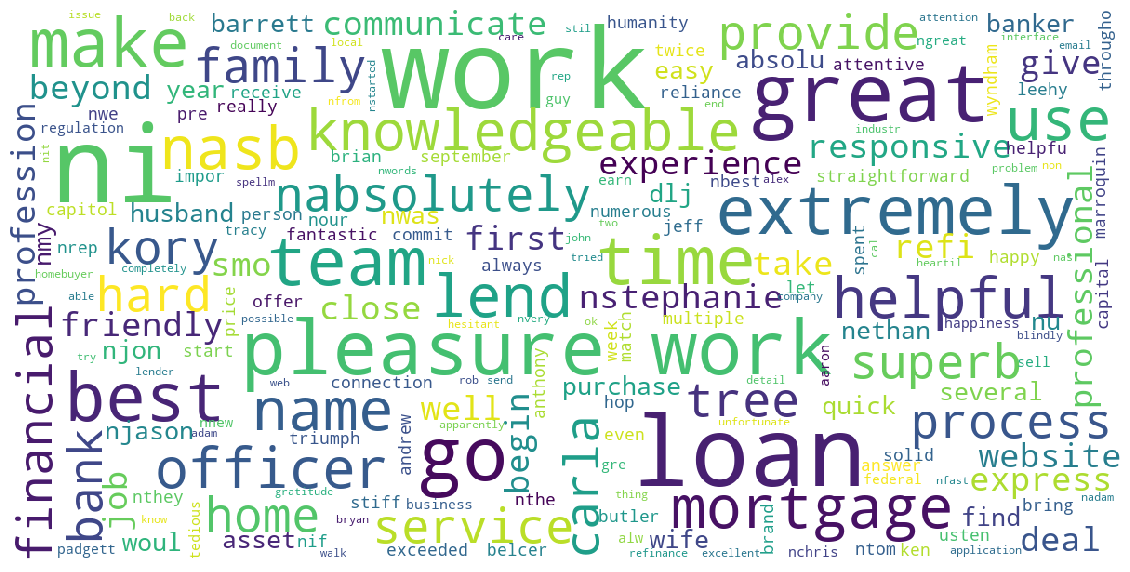

In [49]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["Reviews"])

### In order to undertsand the review of  the customer that they are  happy with the service or not

In [51]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["Reviews", "pos"]].head(10)

,Reviews,pos
200,\r\nfast helpful best service possible heartil...,0.655
267,\r\nstephanie great pleasure work give solid a...,0.643
442,\r\nthey get best deal price match even well f...,0.535
376,\r\ni work tracy padgett completely profession...,0.524
172,\r\ngreat website knowledgeable responsive alw...,0.442
34,great website knowledgeable responsive always ...,0.442
82,\r\nsteven phenomenal job work locate refinanc...,0.441
170,\r\nbest loan officer could hop jeff exceeded ...,0.439
367,\r\ntom pleasure work really take time answer ...,0.393
159,\r\ni work kory carla nasb superb team provide...,0.389


In [52]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["Reviews", "neg"]].head(10)

,Reviews,neg
406,\r\nadam team apparently communicate extremely...,0.428
36,rob helpful get loan close issue end know stil...,0.207
494,\r\nour loan officer happy communicate commit ...,0.203
310,\r\nethan mortgage banker dlj financial absolu...,0.115
134,\r\nit pleasure work alex unfortunate go two f...,0.105
93,\r\nif use reliance first capitol...do let ken...,0.104
191,\r\ni can't begin express happiness work aaron...,0.101
316,\r\ni pleasure work anthony marroquin througho...,0.090
472,\r\ni work person name andrew leehy hard work ...,0.079
5,pleasure work wyndham capital september family...,0.076


In [ ]:
y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

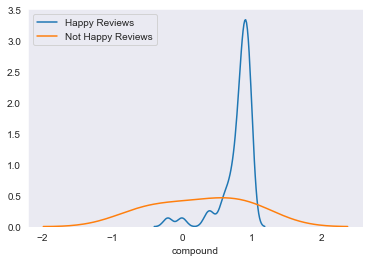

In [59]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['Stars'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Happy Reviews"
    else:
        label = "Not Happy Reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

The above graph shows the distribution of the reviews sentiments among happy reviews and not happy ones. We can see that good reviews are for most of them considered as very positive by Vader. On the contrary, bad reviews tend to have lower compound sentiment scores.

### Intent Analysis

In [116]:
data['INTENT'] = data.sentiment_cat

In [118]:
dara_intent = data[['INTENT','Reviews']]

In [119]:
dara_intent.head()

,INTENT,Reviews
0,Positive,"Great job, Wyndham Capital! Each person was pr..."
1,Positive,Matthew Richardson is professional and helpful...
2,Negative,We had a past experience with Wyndham Mortgage...
3,Negative,We have been dealing with Brad Thomka from the...
4,Positive,I can't express how grateful I am for the supp...


In [120]:
# convert label to a numeric variable
dara_intent['INTENT'] = dara_intent.INTENT.map({'Negative':0, 'Positive':1})

In [121]:
dara_intent.head()

,INTENT,Reviews
0,1,"Great job, Wyndham Capital! Each person was pr..."
1,1,Matthew Richardson is professional and helpful...
2,0,We had a past experience with Wyndham Mortgage...
3,0,We have been dealing with Brad Thomka from the...
4,1,I can't express how grateful I am for the supp...


In [123]:
dara_intent.dtypes

INTENT      int64
Reviews    object
dtype: object

In [125]:
# define X and y
X = dara_intent.Reviews
y = dara_intent.INTENT

### splitting into training and testing sets

In [126]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.shape)

(404,)
(101,)
(101,)
(404,)


In [128]:
import re
def pre_process_text(x):
    x = x.strip()
    x = re.sub(r' +', ' ', x)
    x = re.sub(r"[-()\"#/@;:{}`+=~|.!?,'0-9]", "", x)
    return(x)

### Vectorizing reviews

In [129]:
vect = TfidfVectorizer(analyzer='word',lowercase=True, preprocessor=pre_process_text, ngram_range=(1,2), max_features=1000, max_df=1.0, min_df=10, stop_words=STOPWORDS)

In [130]:
# learn training data vocabulary, then create document-term matrix
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)
X_train_dtm

<404x366 sparse matrix of type '<class 'numpy.float64'>'
	with 8948 stored elements in Compressed Sparse Row format>

In [131]:
# store token names
X_train_tokens = vect.get_feature_names()

In [132]:
# first 50 tokens
print(X_train_tokens[:50])

['Aaron', 'Adam', 'After', 'Alex', 'As', 'Barrett', 'Beneficial', 'But', 'DLJ', 'Dean', 'Even', 'From', 'Great', 'Guaranteed', 'Guaranteed Rate', 'He', 'He great', 'He made', 'His', 'However', 'If', 'Im', 'In', 'It', 'Ive', 'Jon', 'Lending', 'More', 'Mortgage', 'My', 'NASB', 'Once', 'Our', 'Our loan', 'Pacific', 'Pacific Beneficial', 'Peter', 'Rate', 'Read', 'Read More', 'Reliance', 'She', 'Steve', 'Thank', 'Thanks', 'The', 'They', 'This', 'Triumph', 'VA']


In [133]:
# last 50 tokens
print(X_train_tokens[-50:])

['step', 'step way', 'still', 'stressful', 'sure', 'take', 'talked', 'talking', 'team', 'thank', 'thanks', 'things', 'thought', 'throughout', 'throughout process', 'time', 'timely', 'times', 'told', 'took', 'took time', 'top', 'two', 'understood', 'us', 'use', 'used', 'using', 'via', 'want', 'wanted', 'way', 'week', 'weeks', 'well', 'went', 'went beyond', 'whole', 'whole process', 'wife', 'will', 'will recommend', 'within', 'without', 'work', 'worked', 'worked hard', 'working', 'wouldnt', 'years']


In [134]:
# view X_train_dtm as a dense matrix
X_train_dtm.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.22294558],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [135]:
import pandas as pd
dtm = pd.DataFrame(X_train_dtm.toarray(), columns=vect.get_feature_names())

In [136]:
dtm.shape

(404, 366)

### MODEL BUILDING

#### Naive Bayes

In [141]:
# train a Naive Bayes model using X_train_dtm
from sklearn.naive_bayes import MultinomialNB, GaussianNB
nb = MultinomialNB()
#nb = GaussianNB()
nb.fit(dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [142]:
X_test_dtm = vect.transform(X_test)

In [143]:
# make class predictions for X_test_dtm
y_pred_class_train = nb.predict(dtm)
y_pred_class = nb.predict(X_test_dtm.toarray())

In [144]:
# calculate accuracy of class predictions
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.8415841584158416


In [145]:
# confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[ 3 14]
 [ 2 82]]


In [146]:
print(metrics.classification_report(y_train, y_pred_class_train))

              precision    recall  f1-score   support

           0       0.84      0.44      0.58        73
           1       0.89      0.98      0.93       331

    accuracy                           0.88       404
   macro avg       0.87      0.71      0.75       404
weighted avg       0.88      0.88      0.87       404



In [147]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.60      0.18      0.27        17
           1       0.85      0.98      0.91        84

    accuracy                           0.84       101
   macro avg       0.73      0.58      0.59       101
weighted avg       0.81      0.84      0.80       101



In [ ]:
joblib.dump(X_train, 'X_train.pkl')